## Machine config

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

# Audio classification the from-scratch way

We're going to demonstrate the technique of classifying audio samples by first converting the audio into spectrograms, then treating the spectrograms as images. Once we've converted the spectrograms to images, the workflow is just the same as using imagenette or any other image classification task.

What do we need to do?
* Download the data
* Load the data
    - split the data to each element
    - split to train / valid
    - get label
    - zero pad
* Transform the data into spectrograms (skip)
* Load the audio data into a databunch such that we can use our previously-defined `learner` object

Still to come - 1D convolutional models, RNNs with audio… and more, with your contribution :)

# Download the data

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# !cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/ser_traindev.tar.gz /content/.
# !mkdir /content/data
# !mv /content/ser_traindev.tar.gz /content/data
# %cd /content/data
# !tar -xf /content/data/ser_traindev.tar.gz
# %cd /content

/content/data
/content


In [2]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 39.42 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


- after cloning, if you want to import other modules, you shouyld fix the file `exp.nb_11`

`from exp.nb_10c import *` to `from exp.nb_10b import *`


In [4]:
# restart-run
%cd /content/course-v3/nbs/dl2

/content/course-v3/nbs/dl2


In [170]:
# restart-run
from exp.nb_12a import *

In [6]:
# restart-run
%cd /content

/content


In [21]:
root_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser');

In [22]:
train_path = root_path/'train'

In [23]:
audios = get_files(train_path)

In [24]:
# restart-run
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

In [25]:
al=AudioList.from_files(train_path); al

AudioList (7800 items)
[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7760_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7761_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7762_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7763_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7764_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7765_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7766_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7767_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser/train/7768_1_0.p

In [ ]:
al_dev=AudioList.from_files(dev_path); al_dev

In [26]:
al[0].shape

torch.Size([614, 26])

# v2 - save as an image

In [69]:
plt_path = Path('/content/v3/ser')

In [70]:
train_path = plt_path/'train'

- load tensor and save it to ....... image

In [58]:
for idx, fpath in enumerate(al):
    fname = str(plt_train_path/fpath.stem) + '.png'
    # print(fname); break
    plt.imsave(fname, torch.load(fpath))

- save

In [67]:
%cd /content/v3
!tar -zcf ser-img.tar.gz ser/

/content/v3


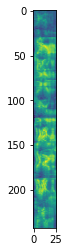

In [ ]:
# plt.imshow(item2.permute(1,2,0))

In [76]:
train_path

PosixPath('/content/v3/ser/train')

In [173]:
il = ImageList.from_files(train_path, tfms=make_rgb)

In [169]:
il[0].save('plt-imsave-and-pil-open.png')

In [79]:
il

ImageList (7800 items)
[PosixPath('/content/v3/ser/train/6819_1_1.png'), PosixPath('/content/v3/ser/train/5904_1_1.png'), PosixPath('/content/v3/ser/train/5150_1_1.png'), PosixPath('/content/v3/ser/train/103_1_0.png'), PosixPath('/content/v3/ser/train/261_0_0.png'), PosixPath('/content/v3/ser/train/7590_1_0.png'), PosixPath('/content/v3/ser/train/3458_1_1.png'), PosixPath('/content/v3/ser/train/5225_0_0.png'), PosixPath('/content/v3/ser/train/1143_0_1.png'), PosixPath('/content/v3/ser/train/2923_1_1.png')...]
Path: /content/v3/ser/train

In [82]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))

In [80]:
# restart-run
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return ''.join(re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

In [92]:
# restart-run
label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='all')
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [98]:
uniqueify(ll.y.items)

[0, 1, 2, 3]

In [131]:
class ToCuda():
    _order=20
    def __call__(self, ad):
        return ad.cuda()

In [145]:
print(inspect.getsource(ResizeFixed))

class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size

    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)



In [146]:
print(inspect.getsource(to_byte_tensor))

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)



In [ ]:
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    c,h = item.size
    return res.view(h,w,-1).permute(2,0,1)

In [174]:
il[0].size

(26, 260)

In [159]:
tfms[:2]

[<function exp.nb_08.make_rgb>, <exp.nb_08.ResizeFixed at 0x7f005f6445d0>]

In [163]:
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    c,h = item.size
    return res.view(c, h).unsqueeze(0)
    # return res.view(h,w,-1).permute(2,0,1)

In [164]:
tmp = compose(il[0], tfms[:2])

In [132]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor, ToCuda()]
il = ImageList.from_files(train_path, tfms = tfms)
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [133]:
x, y = ll.train[0]

In [134]:
x.shape

torch.Size([3, 128, 128])

In [135]:
print(inspect.getsource(show_image))

def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))



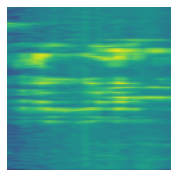

In [136]:
show_image(x.cpu())

In [137]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))

In [138]:
c_in, c_out

(3, 4)

In [139]:
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [140]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr),
ParamScheduler('mom', sched_mom)]

In [141]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func)

In [117]:
!pip install -qq torchmetrics

     |████████████████████████████████| 332 kB 5.0 MB/s 


In [142]:
from torchmetrics import F1
f1 = F1(num_classes=4)

In [143]:
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.245809,0.445051,1.297476,0.471602,00:19
1,1.244118,0.449382,1.426913,0.406509,00:19
2,1.216406,0.462859,1.336968,0.372048,00:19
3,1.189119,0.486283,1.169613,0.500319,00:19
4,1.149366,0.515161,1.159650,0.509892,00:20


/content/course-v3/nbs/dl2/exp/nb_09.py:136: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)


---